# Analysis of mouse retinal transcriptomic and epigenomic data (GLDS-203): Low dose irradiation and hindlimb unloading microgravity in mice

- Project: TRRaC
- Author: Prachi Kothiyal
- Last modified on: 08/16/2022

## Summary
GeneLab dataset GLDS-203 is obtained from a ground-based experiment that uses rodent models to evaluate damage in eye induced by prolonged low-dose radiation and simulated microgravity. Here, we perform an integrated analysis of RNA sequencing and methylation (RRBS) data from female mice subjected to irradiation and/or microgravity with tissues collected at 7 days, 1 or 4 month following exposure to radiation and/or microgravity.

## Dataset
- Raw unnormalized counts and RRBS reads (fastq): https://genelab-data.ndc.nasa.gov/genelab/accession/GLDS-203/ (version 6)

In [ ]:
##Load libraries

#General/visualization
library(data.table)
library(ggplot2)
library(ggridges)
library(dplyr)
library(tidyr)
library(tidyverse)
library(plyr)
library(ggnewscale)
library(ggpubr)
library(rstatix)
library(cowplot)
library(ggpmisc)
library(GGally)
library(gridExtra)
library(grid)
library(ComplexUpset)
library("RColorBrewer")
library(treemapify)
library(ggtree)
library(dendextend)
library(BiocParallel)

#Annotation
library(biomaRt)
organism="org.Mm.eg.db"
library(organism, character.only = TRUE)
library(methylKit)
library("genomation")
library("GenomicRanges")

#Enrichment/over-representation
library(clusterProfiler)
library(enrichplot)
library(ggnewscale)
library(rrvgo)
library(DT)

In [2]:
##Initial setup
setwd("/home/jupyter/MOUNT/integrated")

#Define timepoints and conditions
timepoints=c("7d","1m","4m")
cases=c("HLU","IR","HLU_IR")

#### Process reference annotations

In [ ]:
#Extract gene biotypes and gene names from Biomart
httr::set_config(httr::config(ssl_verifypeer = FALSE))
mart <- useMart('ENSEMBL_MART_ENSEMBL')
mart <- useDataset('mmusculus_gene_ensembl', mart)

annotLookup <- getBM(
  mart = mart,
  attributes = c(
    'ensembl_gene_id',
    'ensembl_transcript_id',
    'external_gene_name',
    'gene_biotype',
    'entrezgene_id'),
  uniqueRows = TRUE)

# Read the gene and CpG island BED files
## Converted UCSC bed files to 1-based as bismark outputs 1-based files
gene.obj=readTranscriptFeatures("/home/jupyter/MOUNT/references/mm10.GRCm38.96.bed", up.flank = 2000,down.flank = 2000, remove.unusual=TRUE, unique.prom = TRUE)
cpg.obj=readFeatureFlank("/home/jupyter/MOUNT/references/cpgi.mm10.bed",feature.flank.name=c("CpGi","shores"), remove.unusual = TRUE)
bedfile<-fread("/home/jupyter/MOUNT/references/mm10.GRCm38.96.bed",header=F)
bedfile<-subset(bedfile,select=c("V1","V4","V6","V2","V3"))
colnames(bedfile)<-c("chr","feature.name","transStrand","transStart","transStop")

#### Define plotting functions for multicollinearity plots

In [4]:
#Lower plots in ggpairs
lowerFn <- function(data, mapping, method = "lm", ...) {
        x <- eval_data_col(data, mapping$x)
        y <- eval_data_col(data, mapping$y)
    
        OK <- complete.cases(x, y)
        x <- x[OK]
        y <- y[OK]
        n <- length(x)
        if(n > 3L){

          p <- ggplot(data = data, mapping = mapping) +
                    geom_point(colour = "dodgerblue1") +
                    geom_smooth(method = method, color = "red", ...)
          p
        }
        else{
         p <- ggplot(data = data, mapping = mapping) +
                    geom_point(colour = "dodgerblue1")
         p
        }
}

#Diagonal in ggpairs
diagFun <- function(data,mapping){
  ggplot(data = data, mapping = mapping)+
    geom_histogram(binwidth=1)
}  

#Upper plots in ggpairs
corFn <- function(data, mapping, method="p", use="pairwise", ...){
              # grab data
              x <- eval_data_col(data, mapping$x)
              y <- eval_data_col(data, mapping$y)
    
              OK <- complete.cases(x, y)
              x <- x[OK]
              y <- y[OK]
              n <- length(x)
        if(n > 3L){
              # calculate correlation
              corr <- cor(x, y, method=method, use=use)
            
            if (abs(corr) < 1) {
              #return(ggally_blank())
            }

              # calculate colour based on correlation value
              colFn <- colorRampPalette(c("dodgerblue4", "floralwhite", "firebrick1"), interpolate ='spline')
              fill <- colFn(100)[findInterval(corr, seq(-1, 1, length=100))]

              ggally_cor(data = data, mapping = mapping, ...) + 
                theme_void() +
                theme(panel.background = element_rect(fill=fill),)
            }
}

#### Load results from differential expression and methylation analyses 

In [5]:
#Differentially expressed genes
degs<-fread("GLDS-203_deg.tsv",header=T) 
degs<-merge(degs,unique(subset(annotLookup,select=c("ensembl_gene_id","external_gene_name"))),
            by.x=c("ensembl"),by.y=c("ensembl_gene_id"))
degs$Group<-gsub(" ","_",degs$Group)

#Differentially methylated sites and regions
dmls<-fread("GLDS-203_dml.tsv",header=T)
dmrs<-fread("GLDS-203_dmr.tsv",header=T)

#### Annotate sites and regions

In [6]:
#Convert methylDiff object to GRanges and annotate differentially methylated sites and regions
#Annotations include gene name, context (promoter, gene body, intergenic) and CpG island or shore
dmls<-dmls %>% dplyr::select(meth.diff,qvalue,chr,start,end,ensembl_gene_id,external_gene_name,Type) %>% dplyr::mutate(Class="DML")
dmrs<-dmrs %>% dplyr::select(meth.diff,qvalue,chr,start,end,ensembl_gene_id,external_gene_name,Type) %>% dplyr::mutate(Class="DMR")
data<-rbind(dmls,dmrs)

gr <- makeGRangesFromDataFrame(data, keep.extra.columns=FALSE,
                                      start.field="start",
                                      end.field="end")

#Island/Shore annotation
diffCpGann=annotateWithFeatureFlank(gr,
                                    cpg.obj$CpGi,cpg.obj$shores,feature.name="CpGi",flank.name="shores")
diffCpGMat<-as.data.frame(getMembers(diffCpGann))
diffCpGMat$CpG<-ifelse(diffCpGMat$CpGi==1,"Island",ifelse(diffCpGMat$shores==1,"Shore","Other"))
data<-cbind(data,diffCpGMat)
        
#Gene annotation
diffCpGann=annotateWithGeneParts(gr,gene.obj)
diffCpGMat<-cbind(getAssociationWithTSS(diffCpGann), as.data.frame(getMembers(diffCpGann)))
data<-cbind(data,diffCpGMat)
data<-merge(data,bedfile,by=c("chr","feature.name"))

#Workaround for a bug in genomation (https://github.com/BIMSBbioinfo/genomation/issues/203)
data$intron<-ifelse((data$start<=data$transStart & data$transStrand=="+"),0,
                    ifelse((data$start>=data$transStop & data$transStrand=="-"),0,data$intron))
data$Region<-ifelse(data$prom==1,"Promoter",ifelse(data$exon==1 | data$intron==1,"Gene body","Intergenic"))

#Filter on genomic context and significance
data<-subset(data, Region!="Intergenic" & qvalue<=0.05)
data$timepoint<-substr(data$Type,1,2)
data<-merge(data,unique(subset(annotLookup,select=c("ensembl_gene_id","entrezgene_id"))),by=c("ensembl_gene_id"))

#### Supplementary Figure 2

Warning message:
“`stat(quantile)` was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(quantile)` instead.”
Picking joint bandwidth of 0.502



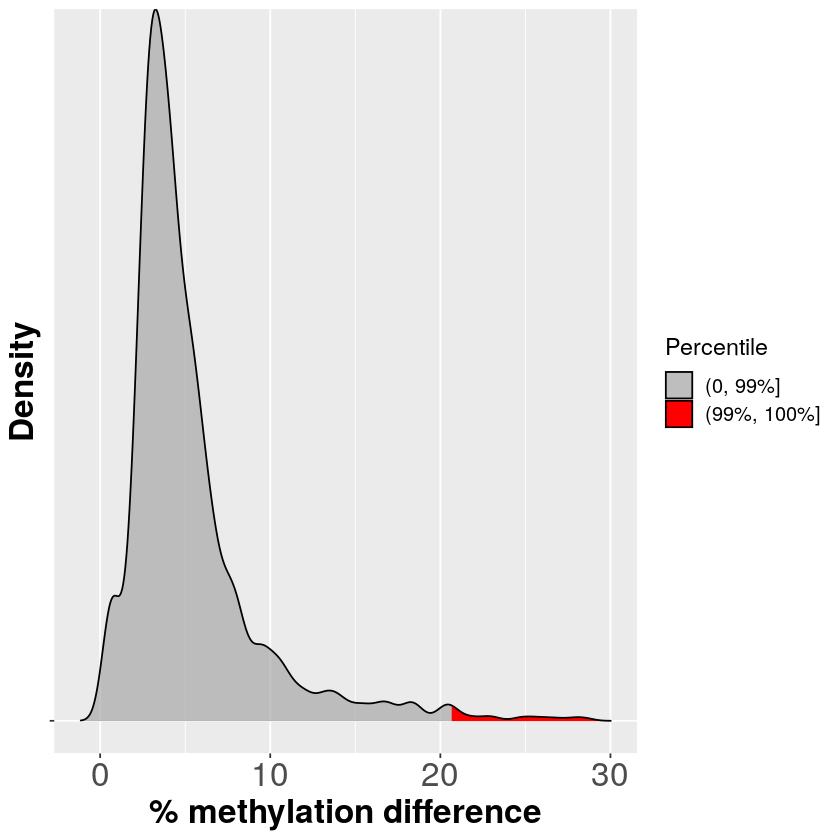

In [7]:
#Distribution of % methylation difference for DMLs in CpG islands at 4m
tmp<-unique(subset(data,CpG=="Island" & qvalue<=0.05 & Class=="DML", select=c("external_gene_name","timepoint")))
tmpCounts<-ddply(tmp,.(external_gene_name),nrow)
tmp<-merge(data,tmpCounts,by=c("external_gene_name"))

ggplot(subset(tmp, qvalue<=0.05 & CpG=="Island" & V1==1 & timepoint=="4m"), aes(x = abs(meth.diff), y="", fill = factor(stat(quantile)))) +
  stat_density_ridges(
    geom = "density_ridges_gradient", calc_ecdf = TRUE,scale=60,
    quantiles = c(0.99)
  ) + xlab("% methylation difference") + ylab("Density") +
  scale_fill_manual(
    name = "Percentile", values = c("#A0A0A0A0", "red"),
    labels = c("(0, 99%]", "(99%, 100%]")
  ) + theme(axis.text=element_text(size=20),axis.title=element_text(size=20, face="bold"), 
                             plot.title = element_text(size=20, face="bold"), plot.subtitle = element_text(size=16),
           legend.title = element_text(size=14), 
        legend.text = element_text(size=12))

#### Figure 2 (correlation, DMG distribution, upset plots for methylation data)

In [8]:
#Plot ggpairs using CpG sites at qvalue<0.05
options(repr.plot.width=20, repr.plot.height=20)
options(warn=-1)

k=0
for (i in 1:length(timepoints)){
    for (j in 1:length(cases)){
        k=k+1
        tmp<-subset(data,Type==paste0(timepoints[i],"_",cases[j]) & Region!="Intergenic" & qvalue<=0.05, 
                    select=c("feature.name","meth.diff","chr","start"))
        colnames(tmp)<-c("gene",paste0(timepoints[i],"\n",cases[j]),"chr","start")
        assign(paste0("data_",timepoints[i],"_",cases[j]),tmp)
        }
    }

merged<-Reduce(function(x,y) merge(x = x, y = y, by = c("gene","chr","start"), all=TRUE),
               list(data_7d_HLU, data_7d_IR, data_7d_HLU_IR, 
                    data_1m_HLU, data_1m_IR, data_1m_HLU_IR,
                    data_4m_HLU, data_4m_IR, data_4m_HLU_IR))
pairsPlot<-merged %>% dplyr::select(-c(gene,chr,start)) %>% ggpairs(lower = list(continuous = wrap(lowerFn, method = "lm")),
  diag = list(continuous = wrap(diagFun)),
  upper = list(continuous = wrap(corFn,size=8,color="black"))) +
theme(axis.text.x = element_text(angle=90, hjust=1, size=16), axis.text.y = element_text(size=16), 
      strip.text = element_text(size = 20,face="bold"))

In [9]:
#DMG distribution across CpG islands/shores
data$Sign<-ifelse(data$meth.diff<0,"Hypo","Hyper")
tmp<-ddply(subset(data, abs(meth.diff)>=10 & qvalue<=0.05 & Region!="Intergenic" &CpG!="Other"),
           .(Type,CpG,Sign),nrow)
colnames(tmp)<-c("Group","CpG","Sign","V1")
tmp$Group<-gsub("_","\n",tmp$Group)
tmp$Group <- factor(tmp$Group, levels = c("7d\nHLU", "7d\nIR", "7d\nHLU\nIR",
                                                 "1m\nHLU", "1m\nIR", "1m\nHLU\nIR",
                                                 "4m\nHLU", "4m\nIR", "4m\nHLU\nIR"))

plotIsland<-ggplot(tmp, aes(x=Group, y=V1, fill=CpG)) + 
  geom_col(stat="identity",position = position_dodge(width = 0.87)) + 
          font("xlab", size = 22, face="bold")+
          scale_fill_manual(values=c("darkgreen","darkgoldenrod2")) +
          font("ylab", size = 22, face="bold")+
          font("xy.text", size = 20) +
          font("legend.title", size=22,face = "bold")+ theme(legend.title = element_blank()) + 
          theme(legend.spacing.x = unit(0.35, 'cm')) + labs(y="Number of DML or DMR") + 
          font("legend.text", size=22) + theme(legend.position="top", 
                        panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
        facet_grid(Sign~.)

In [10]:
#Upset plots for DMGs
tmp<-unique(subset(data,qvalue<=0.05 & abs(meth.diff) >= 10),select=c("external_gene_name","Type"))
tmp$Type <- factor(tmp$Type, levels = c("7d_HLU", "7d_IR", "7d_HLU_IR",
                                                 "1m_HLU", "1m_IR", "1m_HLU_IR",
                                                 "4m_HLU", "4m_IR", "4m_HLU_IR"))
df<-dcast(tmp, external_gene_name~Type, length)
Groups = colnames(df)[2:10]
plotUpset<-upset(df, Groups, name='Groups', width_ratio=0.1, min_size=0, min_degree=2, set_sizes=FALSE,
      queries=list(
        upset_query(set='7d_HLU', fill='green'),
        upset_query(set='7d_IR', fill='magenta'),
        upset_query(set='7d_HLU_IR', fill='orange'),
        upset_query(set='1m_HLU', fill='green'),
        upset_query(set='1m_IR', fill='magenta'),
        upset_query(set='1m_HLU_IR', fill='orange'),
        upset_query(set='4m_HLU', fill='green'),
        upset_query(set='4m_IR', fill='magenta'),
        upset_query(set='4m_HLU_IR', fill='orange')
      ),
      themes=upset_default_themes(text=element_text(size=24,face="bold"), 
                                  axis.title=element_text(face="bold",size=26),panel.border = element_rect(colour = "black", fill=NA, size=1)),
      sort_intersections_by='degree',
      base_annotations=list('Size'=(intersection_size(counts=FALSE))),
       matrix=intersection_matrix(
      geom=geom_point(
        shape='square filled',
        size=5
      )
  )
)

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


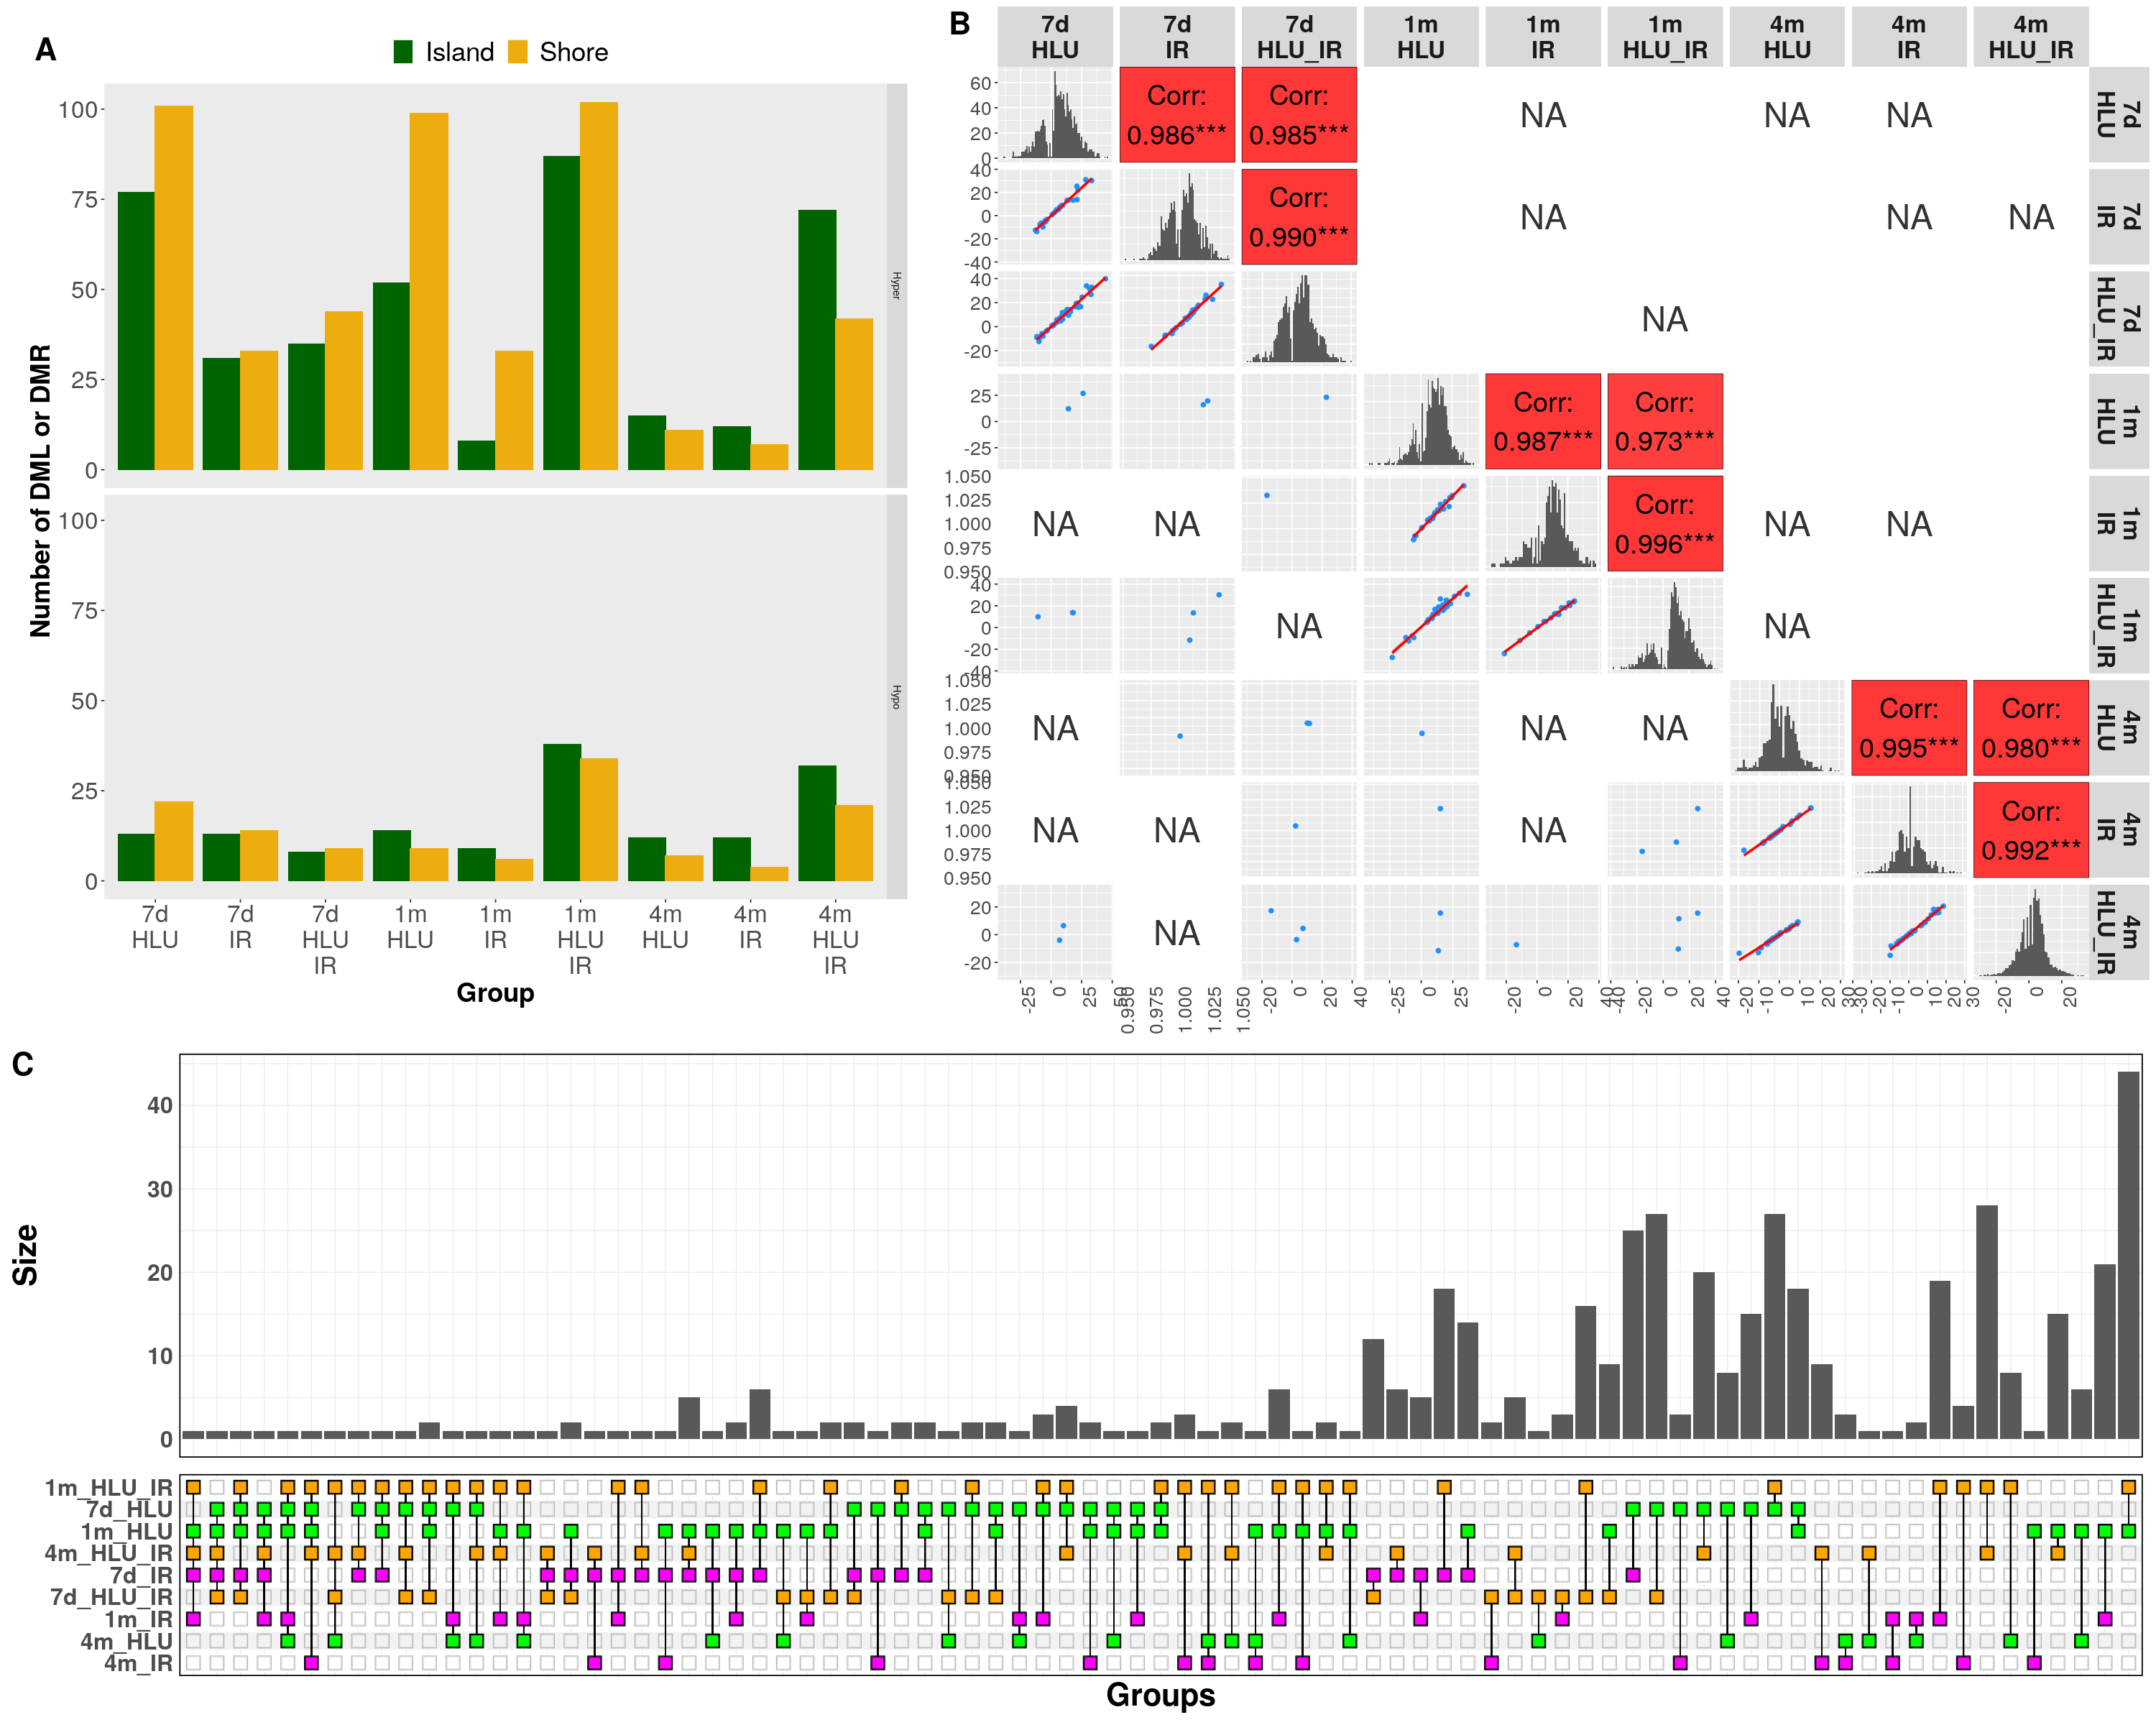

In [11]:
#Create Figure 2
options(repr.plot.width=25, repr.plot.height=20)
plot_grid(plot_grid(plot_grid(plotIsland,labels=c("A"),label_size = 26),
    plot_grid(ggmatrix_gtable(pairsPlot),labels=c("B"),label_size = 26),
                    nrow=1, rel_widths=c(1.5,1.95),scale=c(0.95,1)),
          plot_grid(plotUpset,nrow=1,labels=c("C"),label_size = 26),
          nrow=2,rel_heights=c(1.9,1.25))

#### Over-representation analysis (GO biological processes) for differentially methylated genes 
- Only genes in RRBS data are used as backgroud

In [ ]:
rrbsGenes<-fread("/home/jupyter/MOUNT/integrated/bismark/glds203/glds203_rrbs_genes.txt",header=T)
expGenes<-fread("/home/jupyter/MOUNT/integrated/expressed_genes.txt",header=T)
colnames(rrbsGenes)<-c("external_gene_name","ensembl_gene_id","biotype")
bkgGenes<-unique(subset(rrbsGenes,select=c("ensembl_gene_id")))

k=0
for (i in 1:length(timepoints)){
    for (j in 1:length(cases)){
        k=k+1
        tmpDmgsub<-unique(subset(data,Type==paste0(timepoints[i],"_",cases[j]) & qvalue<=0.05 & 
                              ((Class=="DMR" & meth.diff>=2) | (Class=="DML" & meth.diff>=10)),
                               select=c("ensembl_gene_id","Class")))
        
        #p-value cutoff is set at 1 so all BPs are in the output and filters can be applied during analysis
        ego <- enrichGO(gene  = unique(as.vector(tmpDmgsub$ensembl_gene_id)),
                OrgDb         = org.Mm.eg.db,
                keyType       = 'ENSEMBL',
                minGSSize     = 5,maxGSSize     = 800,
                universe      = as.character(unique(as.vector(bkgGenes$ensembl_gene_id))),
                ont           = "BP",
                pAdjustMethod = "BH",
                pvalueCutoff  = 1,
                qvalueCutoff  = 1,
                readable = TRUE)
        
            gseaRes<-data.frame(ego)
            gseaRes<-subset(gseaRes,Count>2)
            if(dim(gseaRes)[1]>0){
                print("in")
                gseaRes$Dataset<-"GLDS-203"
                gseaRes$Group<-paste0(timepoints[i],"_",cases[j])
                write.table(gseaRes,paste0("Pathways/GLDS-203_",paste0(timepoints[i],"_",cases[j]),"_clusterProfiler.GO.BP.dml.hyper.tsv"),sep="\t",quote=FALSE,row.names=F)
        }
    }
}

#### Gene set enrichment analysis for expression data
- Wald test statistic from DESeq2 is used for ranking the genes
- Writes GSEA results based on differential expression in each timepoint/condition vs. time-matched controls

In [ ]:
setwd("/home/jupyter/MOUNT/integrated/Pathways")
outputTable<-degs
for (i in 1:length(timepoints)){
  for (j in 1:length(cases)){
    title<-paste0(timepoints[i],"_",cases[j])
    tmpData<-subset(as.data.frame(outputTable),Group==paste0(timepoints[i],"_",cases[j]), select=c("stat","external_gene_name"))
    tmpData <- tmpData %>% dplyr::select(stat,external_gene_name)
    
    rankMetric <- tmpData$stat
    names(rankMetric) <- tmpData$external_gene_name
    rankMetric <- sort(rankMetric, decreasing = TRUE)
    
    ####GO####
    gseaGO <- gseGO(geneList=rankMetric,
                                     ont ="BP",
                                     keyType="SYMBOL",
                                     pvalueCutoff = 0.25,
                                     by = "fgsea",
                                     minGSSize = 5, maxGSSize = 800,
                                     exponent=1, eps = 0,
                                     pAdjustMethod = "BH",
                                     OrgDb = org.Mm.eg.db,
                                     verbose=FALSE)
    if(dim(gseaGO)[1]>0){
            gseaRes<-data.frame(gseaGO)
            gseaRes$Dataset<-"GLDS-203"
            gseaRes$Group<-title
            write.table(gseaRes,paste0("GLDS-203_",title,"_clusterProfiler.GO.BP.symbol.tsv"),sep="\t",quote=FALSE,row.names=F)
            }
    }
}

#### Group or timepoint specific GO terms reduced with REVIGO

In [ ]:
setwd("/home/jupyter/MOUNT/integrated/Pathways")
g7d_HLU=as.data.frame(fread("GLDS-203_7d_HLU_clusterProfiler.GO.BP.symbol.tsv",header=T))
g7d_IR=as.data.frame(fread("GLDS-203_7d_IR_clusterProfiler.GO.BP.symbol.tsv",header=T))
g7d_HLU_IR=as.data.frame(fread("GLDS-203_7d_HLU_IR_clusterProfiler.GO.BP.symbol.tsv",header=T))
g1m_HLU=as.data.frame(fread("GLDS-203_1m_HLU_clusterProfiler.GO.BP.symbol.tsv",header=T))
g1m_IR=as.data.frame(fread("GLDS-203_1m_IR_clusterProfiler.GO.BP.symbol.tsv",header=T))
g1m_HLU_IR=as.data.frame(fread("GLDS-203_1m_HLU_IR_clusterProfiler.GO.BP.symbol.tsv",header=T))
g4m_HLU=as.data.frame(fread("GLDS-203_4m_HLU_clusterProfiler.GO.BP.symbol.tsv",header=T))
g4m_IR=as.data.frame(fread("GLDS-203_4m_IR_clusterProfiler.GO.BP.symbol.tsv",header=T))
g4m_HLU_IR=as.data.frame(fread("GLDS-203_4m_HLU_IR_clusterProfiler.GO.BP.symbol.tsv",header=T))

merged<-rbind(g7d_HLU,g7d_IR,g7d_HLU_IR,g1m_HLU,g1m_IR,g1m_HLU_IR,g4m_HLU,g4m_IR,g4m_HLU_IR)
merged<-subset(merged,select=c("ID","core_enrichment","Group","p.adjust"))
merged$Type<-"DEG"
colnames(merged)<-c("ID","geneID","Group","p.adjust","Type")
merged$Group<-paste0(merged$Group,"_",merged$Type)
merged<-subset(merged,select=c("ID","Group","p.adjust"))
df<-reshape2::dcast(merged, ID~Group, value.var='p.adjust',length)
df<-reshape(merged, idvar = "ID", timevar = "Group", direction = "wide")
df[is.na(df)] <- 1
df$sum<-rowSums(df[,2:10]<0.05)
df <- df %>% dplyr::mutate(id=1:n()) %>%
  rowwise(id) %>% mutate(product=min(c_across(p.adjust.7d_HLU_DEG:p.adjust.4m_HLU_IR_DEG)))
goBP<-subset(df,(`p.adjust.1m_IR_DEG`<0.05 | `p.adjust.7d_IR_DEG`<0.05 | `p.adjust.4m_IR_DEG`<0.05) & 
       `p.adjust.1m_HLU_IR_DEG`==1 & `p.adjust.7d_HLU_IR_DEG`==1 & `p.adjust.4m_HLU_IR_DEG`==1 &
       `p.adjust.1m_HLU_DEG`==1 & `p.adjust.7d_HLU_DEG`==1 & `p.adjust.4m_HLU_DEG`==1 & sum>=2, select=c("ID","product")) %>% dplyr::arrange(product)
simMatrix <- calculateSimMatrix(goBP$ID,
                                orgdb="org.Mm.eg.db",
                                ont="BP",
                                method="Rel")
    scores <- setNames(-log10(goBP$product), goBP$ID)
    reducedTerms_IR <- reduceSimMatrix(simMatrix,
                                scores,
                                threshold=0.75,
                                orgdb="org.Mm.eg.db")

goBP<-subset(df,(`p.adjust.1m_HLU_IR_DEG`<0.05 | `p.adjust.7d_HLU_IR_DEG`<0.05 | `p.adjust.4m_HLU_IR_DEG`<0.05) & 
       `p.adjust.1m_IR_DEG`==1 & `p.adjust.7d_IR_DEG`==1 & `p.adjust.4m_IR_DEG`==1 &
       `p.adjust.1m_HLU_DEG`==1 & `p.adjust.7d_HLU_DEG`==1 & `p.adjust.4m_HLU_DEG`==1 & sum>=2, select=c("ID","product")) %>% dplyr::arrange(product)
simMatrix <- calculateSimMatrix(goBP$ID,
                                orgdb="org.Mm.eg.db",
                                ont="BP",
                                method="Rel")
    scores <- setNames(-log10(goBP$product), goBP$ID)
    reducedTerms_HLU_IR <- reduceSimMatrix(simMatrix,
                                scores,
                                threshold=0.75,
                                orgdb="org.Mm.eg.db")

goBP<-subset(df,(`p.adjust.1m_HLU_DEG`<0.05 | `p.adjust.7d_HLU_DEG`<0.05 | `p.adjust.4m_HLU_DEG`<0.05) & 
       `p.adjust.1m_HLU_IR_DEG`==1 & `p.adjust.7d_HLU_IR_DEG`==1 & `p.adjust.4m_HLU_IR_DEG`==1 &
       `p.adjust.1m_IR_DEG`==1 & `p.adjust.7d_IR_DEG`==1 & `p.adjust.4m_IR_DEG`==1 & sum>=2, select=c("ID","product")) %>% dplyr::arrange(product)
simMatrix <- calculateSimMatrix(goBP$ID,
                                orgdb="org.Mm.eg.db",
                                ont="BP",
                                method="Rel")
    scores <- setNames(-log10(goBP$product), goBP$ID)
    reducedTerms_HLU <- reduceSimMatrix(simMatrix,
                                scores,
                                threshold=0.75,
                                orgdb="org.Mm.eg.db")

goBP<-subset(df,(`p.adjust.7d_IR_DEG`<0.05 | `p.adjust.7d_HLU_DEG`<0.05 | `p.adjust.7d_HLU_IR_DEG`<0.05) & 
       `p.adjust.1m_HLU_DEG`==1 & `p.adjust.1m_IR_DEG`==1 & `p.adjust.1m_HLU_IR_DEG`==1 &
       `p.adjust.4m_HLU_DEG`==1 & `p.adjust.4m_IR_DEG`==1 & `p.adjust.4m_HLU_IR_DEG`==1 & sum>=2, select=c("ID","product")) %>% dplyr::arrange(product)
simMatrix <- calculateSimMatrix(goBP$ID,
                                orgdb="org.Mm.eg.db",
                                ont="BP",
                                method="Rel")
    scores <- setNames(-log10(goBP$product), goBP$ID)
    reducedTerms_7d <- reduceSimMatrix(simMatrix,
                                scores,
                                threshold=0.9,
                                orgdb="org.Mm.eg.db")

goBP<-subset(df,`p.adjust.7d_IR_DEG`==1 & `p.adjust.7d_HLU_DEG`==1 & `p.adjust.7d_HLU_IR_DEG`==1 & 
       (`p.adjust.1m_HLU_DEG`<0.05 | `p.adjust.1m_IR_DEG`<0.05 | `p.adjust.1m_HLU_IR_DEG`<0.05) &
       `p.adjust.4m_HLU_DEG`==1 & `p.adjust.4m_IR_DEG`==1 & `p.adjust.4m_HLU_IR_DEG`==1 & sum>=2, select=c("ID","product")) %>% dplyr::arrange(product)
simMatrix <- calculateSimMatrix(goBP$ID,
                                orgdb="org.Mm.eg.db",
                                ont="BP",
                                method="Rel")
    scores <- setNames(-log10(goBP$product), goBP$ID)
    reducedTerms_1m <- reduceSimMatrix(simMatrix,
                                scores,
                                threshold=0.9,
                                orgdb="org.Mm.eg.db")

goBP<-subset(df,`p.adjust.7d_IR_DEG`==1 & `p.adjust.7d_HLU_DEG`==1 & `p.adjust.7d_HLU_IR_DEG`==1 & 
       `p.adjust.1m_HLU_DEG`==1 & `p.adjust.1m_IR_DEG`==1 & `p.adjust.1m_HLU_IR_DEG`==1 &
       (`p.adjust.4m_HLU_DEG`<0.05 | `p.adjust.4m_IR_DEG`<0.05 | `p.adjust.4m_HLU_IR_DEG`<0.05) & sum>=2, select=c("ID","product")) %>% dplyr::arrange(product)
simMatrix <- calculateSimMatrix(goBP$ID,
                                orgdb="org.Mm.eg.db",
                                ont="BP",
                                method="Rel")
    scores <- setNames(-log10(goBP$product), goBP$ID)
    reducedTerms_4m <- reduceSimMatrix(simMatrix,
                                scores,
                                threshold=0.9,
                                orgdb="org.Mm.eg.db")

#### Figure 3 (A and B); shared GO BP's across timepoints and exposures

In [27]:
##HLU
merged<-rbind(g7d_HLU,g1m_HLU,g4m_HLU) %>%
    dplyr::mutate(count = str_count(core_enrichment, "/") + 1) %>%
    dplyr::mutate(GeneRatio=count/setSize)
descCounts<-ddply(merged,.(Description),nrow)
colnames(descCounts)<-c("Description","GroupCount")
merged<-merge(merged,descCounts) %>% filter(GroupCount==3) %>% 
        dplyr::mutate(Group = fct_relevel(Group, "7d_HLU", "1m_HLU", "4m_HLU"))

hlu<-ggplot(merged, aes(x = GeneRatio, y = fct_reorder(Description, GeneRatio))) + 
               geom_point(aes(size =abs(NES), color = as.factor(sign(NES)))) +
                ylab(NULL) + scale_color_manual(name = "Sign(NES)",values = c("-1" = "blue", "1"="red"),labels=c("-","+")) +
        scale_size(name = "|NES|") + facet_grid(.~Group)

##IR
merged<-rbind(g7d_IR,g1m_IR,g4m_IR) %>%
    dplyr::mutate(count = str_count(core_enrichment, "/") + 1) %>%
    dplyr::mutate(GeneRatio=count/setSize)
descCounts<-ddply(merged,.(Description),nrow)
colnames(descCounts)<-c("Description","GroupCount")
merged<-merge(merged,descCounts) %>% filter(GroupCount==3) %>% 
        dplyr::mutate(Group = fct_relevel(Group, "7d_IR", "1m_IR", "4m_IR"))

ir<-ggplot(merged, aes(x = GeneRatio, y = fct_reorder(Description, GeneRatio))) + 
               geom_point(aes(size =abs(NES), color = as.factor(sign(NES)))) +
                ylab(NULL) + scale_color_manual(name = "Sign(NES)",values = c("-1" = "blue", "1"="red"),labels=c("-","+")) +
        scale_size(name = "|NES|") + facet_grid(.~Group)

##HLU_IR
merged<-rbind(g7d_HLU_IR,g1m_HLU_IR,g4m_HLU_IR) %>%
    dplyr::mutate(count = str_count(core_enrichment, "/") + 1) %>%
    dplyr::mutate(GeneRatio=count/setSize)
descCounts<-ddply(merged,.(Description),nrow)
colnames(descCounts)<-c("Description","GroupCount")
merged<-merge(merged,descCounts) %>% filter(GroupCount==3) %>% 
        dplyr::mutate(Group = fct_relevel(Group, "7d_HLU_IR", "1m_HLU_IR", "4m_HLU_IR"))

hlu_ir<-ggplot(merged, aes(x = GeneRatio, y = fct_reorder(Description, GeneRatio))) + 
               geom_point(aes(size =abs(NES), color = as.factor(sign(NES)))) +
                ylab(NULL) + scale_color_manual(name = "Sign(NES)",values = c("-1" = "blue", "1"="red"),labels=c("-","+")) +
        scale_size(name = "|NES|") + facet_grid(.~Group)

##All groups
merged<-rbind(g7d_HLU,g7d_IR,g7d_HLU_IR,g1m_HLU,g1m_IR,g1m_HLU_IR,g4m_HLU,g4m_IR,g4m_HLU_IR) %>%
    dplyr::mutate(count = str_count(core_enrichment, "/") + 1) %>%
    dplyr::mutate(GeneRatio=count/setSize)
descCounts<-ddply(merged,.(Description),nrow)
colnames(descCounts)<-c("Description","GroupCount")
merged<-merge(merged,descCounts) %>% filter(GroupCount>8) %>% 
        dplyr::mutate(Group = fct_relevel(Group, "7d_HLU", "7d_IR", "7d_HLU_IR","1m_HLU", "1m_IR", "1m_HLU_IR","4m_HLU", "4m_IR", "4m_HLU_IR"))

t_all<-ggplot(merged, aes(x = GeneRatio, y = fct_reorder(Description, GeneRatio))) + 
               geom_point(aes(size =abs(NES), color = as.factor(sign(NES)))) +
                ylab(NULL) + scale_color_manual(name = "Sign(NES)",values = c("-1" = "blue", "1"="red"),labels=c("-","+")) +
        scale_size(name = "|NES|") + facet_grid(.~Group)
merged<-unique(subset(merged,select=c("core_enrichment","Group")) %>% separate_rows(core_enrichment,sep="\\/"))

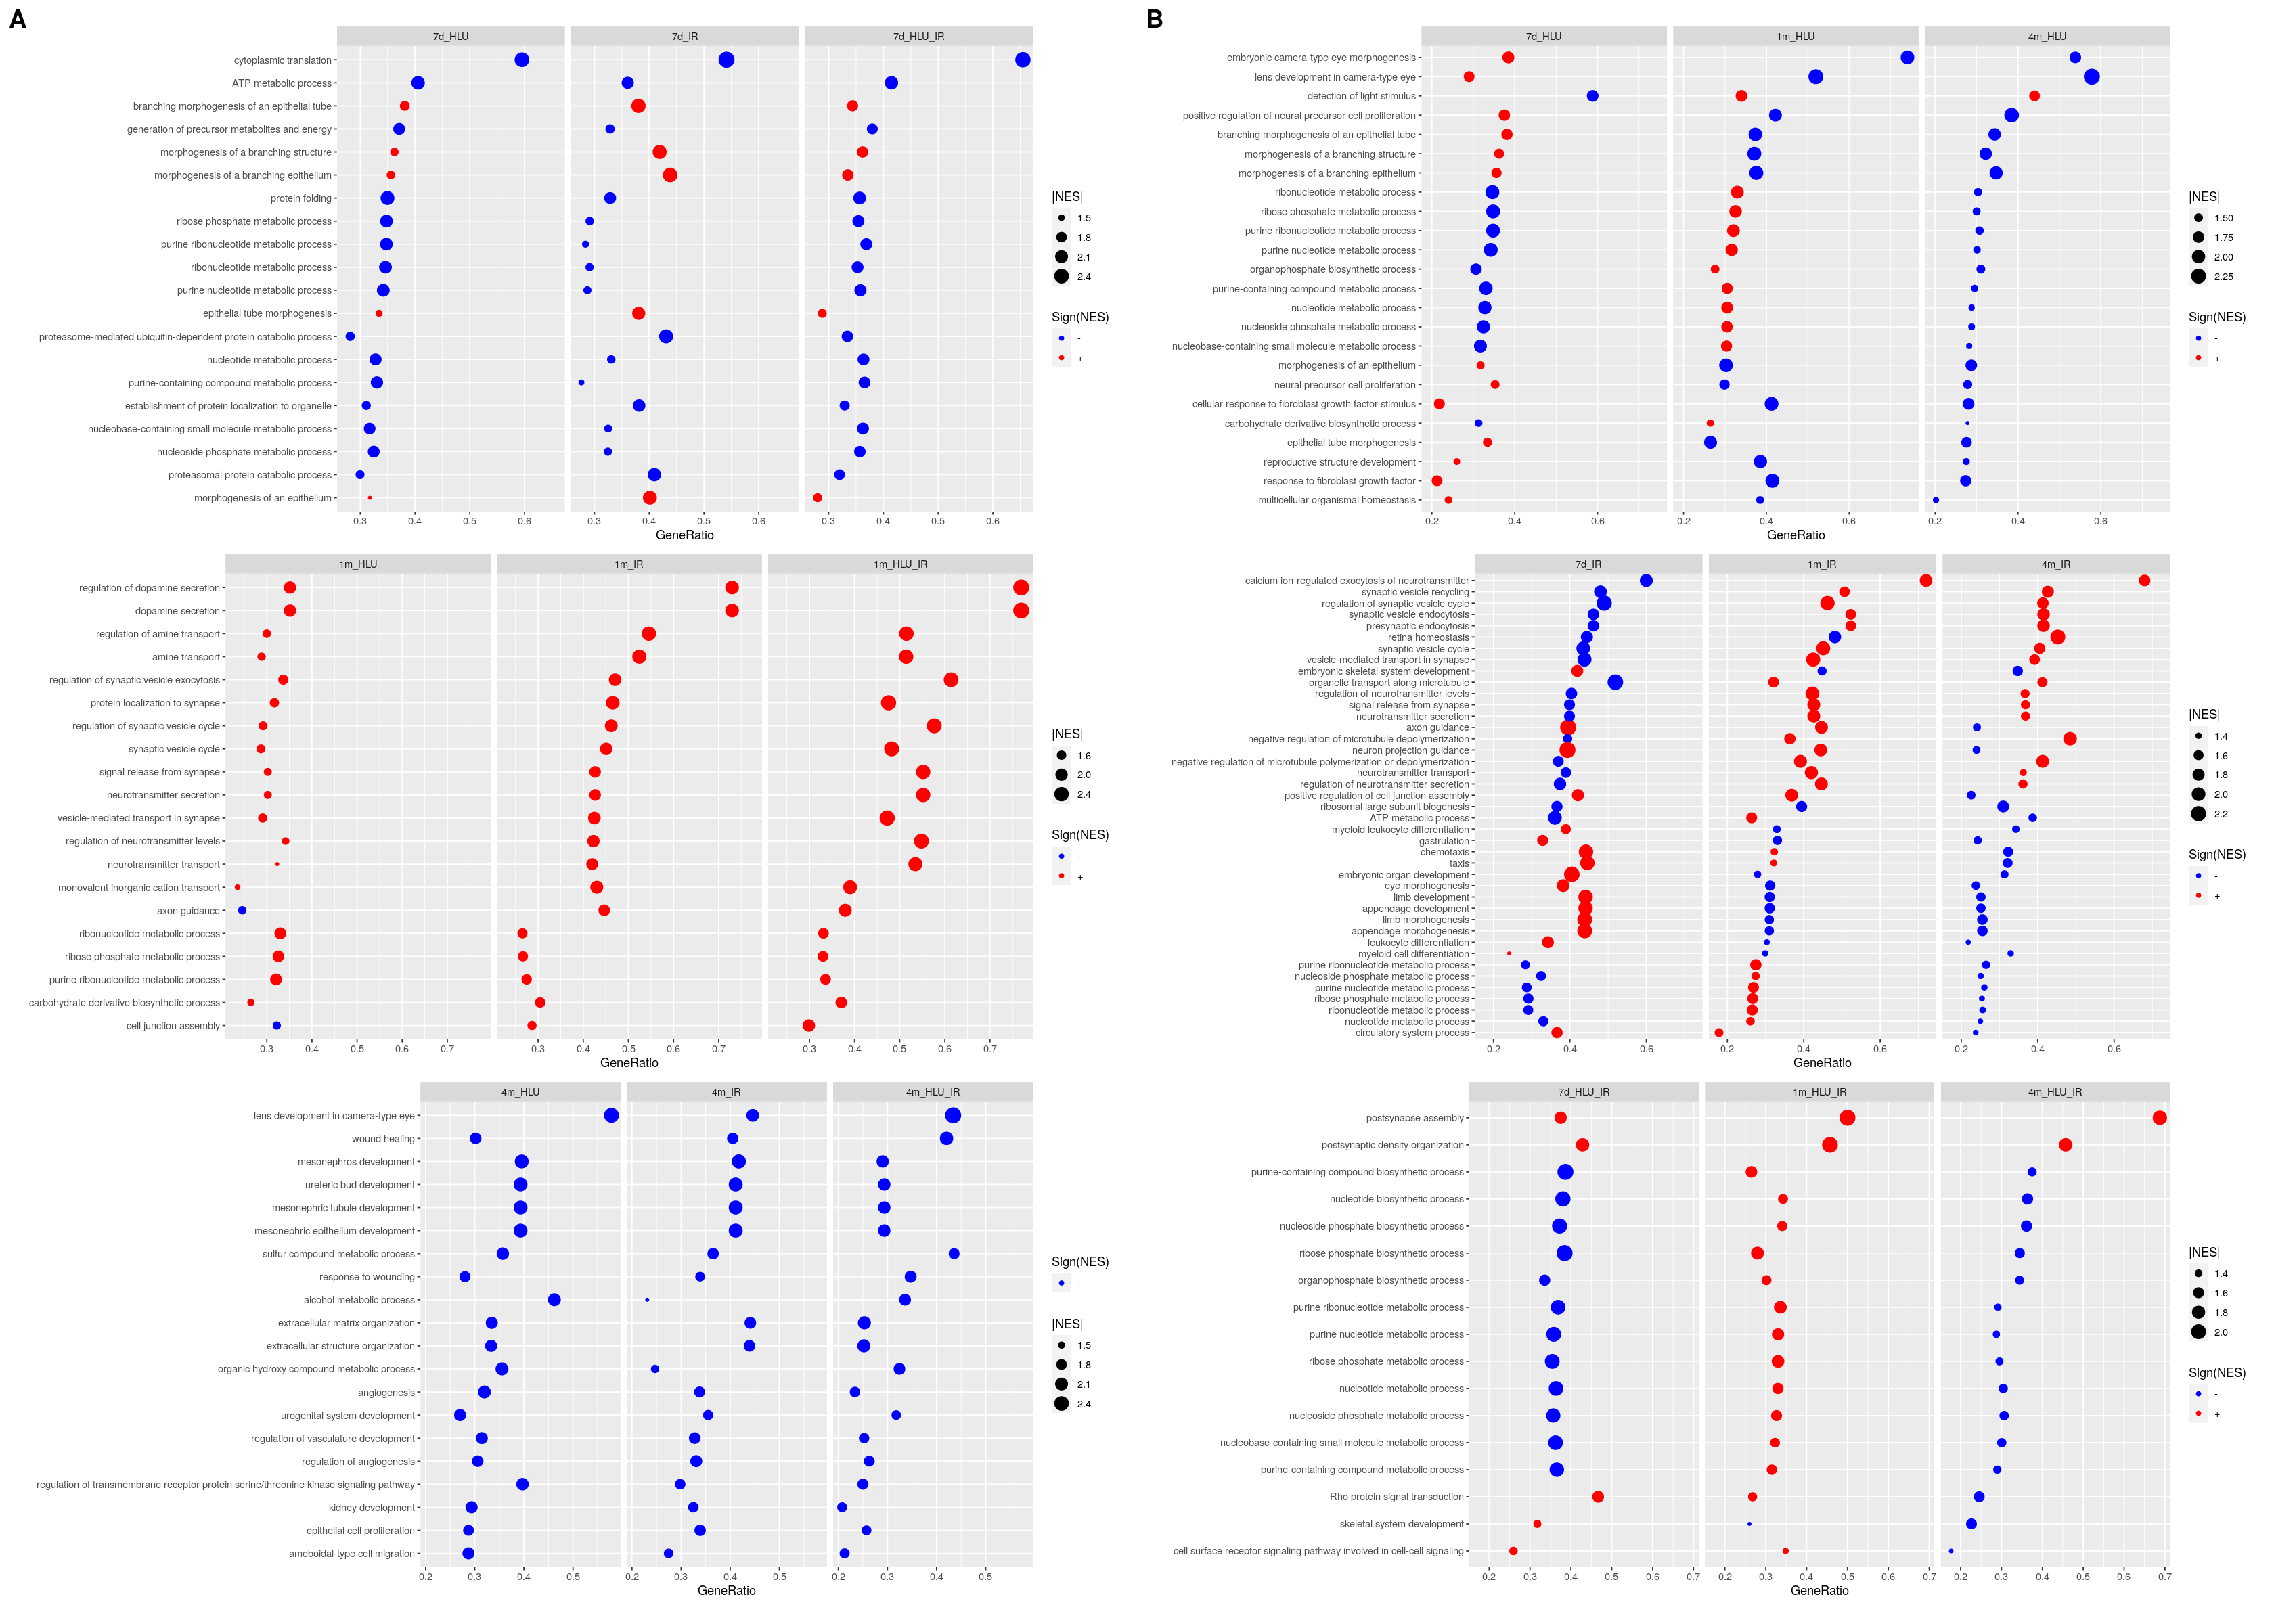

In [29]:
options(repr.plot.width=18, repr.plot.height=15)
##7d
par(mfrow=c(1,3))
merged<-Reduce(function(x,y) merge(x = x, y = y, by = c("ID")),
               list(g7d_HLU[c("ID","p.adjust")], g7d_IR[c("ID","p.adjust")], g7d_HLU_IR[c("ID","p.adjust")]))
merged$p<-merged$p.adjust.x*merged$p.adjust.y*merged$p.adjust
merged <- merged %>% dplyr::arrange(p)

    goBP<-unique(subset(merged[1:20,],select=c("ID","p")))

merged<-rbind(g7d_HLU,g7d_IR,g7d_HLU_IR) 
merged <- merge(merged,goBP,by=c("ID")) %>%
    dplyr::mutate(count = str_count(core_enrichment, "/") + 1) %>%
    dplyr::mutate(GeneRatio=count/setSize)
merged<-merge(merged,descCounts) %>% 
        dplyr::mutate(Group = fct_relevel(Group, "7d_HLU", "7d_IR", "7d_HLU_IR")) %>% dplyr::arrange(p)

t7d<-ggplot(merged, aes(x = GeneRatio, y = fct_reorder(Description, GeneRatio))) + 
               geom_point(aes(size =abs(NES), color = as.factor(sign(NES)))) +
                ylab(NULL) + scale_color_manual(name = "Sign(NES)",values = c("-1" = "blue", "1"="red"),labels=c("-","+")) +
        scale_size(name = "|NES|") + facet_grid(.~Group)

##1m
merged<-Reduce(function(x,y) merge(x = x, y = y, by = c("ID")),
               list(g1m_HLU[c("ID","p.adjust")], g1m_IR[c("ID","p.adjust")], g1m_HLU_IR[c("ID","p.adjust")]))
merged$p<-merged$p.adjust.x*merged$p.adjust.y*merged$p.adjust
merged <- merged %>% dplyr::arrange(p)

    goBP<-unique(subset(merged[1:20,],select=c("ID","p")))

merged<-rbind(g1m_HLU,g1m_IR,g1m_HLU_IR) 
merged <- merge(merged,goBP,by=c("ID")) %>%
    dplyr::mutate(count = str_count(core_enrichment, "/") + 1) %>%
    dplyr::mutate(GeneRatio=count/setSize)
merged<-merge(merged,descCounts) %>% 
        dplyr::mutate(Group = fct_relevel(Group, "1m_HLU", "1m_IR", "1m_HLU_IR")) %>% dplyr::arrange(p)

t1m<-ggplot(merged, aes(x = GeneRatio, y = fct_reorder(Description, GeneRatio))) + 
               geom_point(aes(size =abs(NES), color = as.factor(sign(NES)))) +
                ylab(NULL) + scale_color_manual(name = "Sign(NES)",values = c("-1" = "blue", "1"="red"),labels=c("-","+")) +
        scale_size(name = "|NES|") + facet_grid(.~Group)

##4m
merged<-Reduce(function(x,y) merge(x = x, y = y, by = c("ID")),
               list(g4m_HLU[c("ID","p.adjust")], g4m_IR[c("ID","p.adjust")], g4m_HLU_IR[c("ID","p.adjust")]))
merged$p<-merged$p.adjust.x*merged$p.adjust.y*merged$p.adjust
merged <- merged %>% dplyr::arrange(p)

    goBP<-unique(subset(merged[1:20,],select=c("ID","p")))

merged<-rbind(g4m_HLU,g4m_IR,g4m_HLU_IR) 
merged <- merge(merged,goBP,by=c("ID")) %>%
    dplyr::mutate(count = str_count(core_enrichment, "/") + 1) %>%
    dplyr::mutate(GeneRatio=count/setSize)
merged<-merge(merged,descCounts) %>% 
        dplyr::mutate(Group = fct_relevel(Group, "4m_HLU", "4m_IR", "4m_HLU_IR")) %>% dplyr::arrange(p)

t4m<-ggplot(merged, aes(x = GeneRatio, y = fct_reorder(Description, GeneRatio))) + 
               geom_point(aes(size =abs(NES), color = as.factor(sign(NES)))) +
                ylab(NULL) + scale_color_manual(name = "Sign(NES)",values = c("-1" = "blue", "1"="red"),labels=c("-","+")) +
        scale_size(name = "|NES|") + facet_grid(.~Group)

options(repr.plot.width=28, repr.plot.height=20)
plot_grid(plot_grid(t7d,t1m,t4m,nrow=3),plot_grid(hlu,ir,hlu_ir,nrow=3),
          labels=c("A","B"), label_size = 22, nrow=1, scale = 0.975)

#### Common genes based on differential expression and methylation analysis

In [25]:
tmpDeg<-subset(degs,padj<=0.05)
tmpDml<-subset(data,qvalue<=0.05)
shared<-merge(subset(tmpDeg,select=c("external_gene_name","Group","padj","log2FoldChange")),
             unique(subset(tmpDml,select=c("external_gene_name","Type","qvalue","meth.diff","Class"))),
             by.x=c("Group","external_gene_name"),
             by.y=c("Type","external_gene_name"))
shared           

Group,external_gene_name,padj,log2FoldChange,qvalue,meth.diff,Class
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1m_HLU_IR,B4galt6,0.0004722236,0.3561548,1.862858e-02,-3.8961039,DML
1m_HLU_IR,Kcnip3,0.0249913583,0.3460296,4.759343e-02,-14.2857143,DML
1m_HLU_IR,Lamp5,0.0270864064,0.2992105,3.173003e-02,10.4760188,DMR
1m_HLU_IR,Nacad,0.0036501894,0.3097036,3.579612e-02,20.2197802,DML
1m_HLU_IR,Rundc3a,0.0101193302,0.2886019,4.750661e-02,23.9859438,DML
1m_HLU_IR,Sphkap,0.0206462740,0.2156749,4.635335e-02,17.9750615,DML
1m_HLU_IR,Tle3,0.0002711715,0.3648622,4.996638e-02,7.3033708,DML
7d_HLU,Cdk14,0.0154441402,-0.2369222,4.070166e-02,2.8125000,DML
7d_HLU,Eef1a1,0.0216845856,-0.2316853,2.970011e-02,-11.7431299,DML
